# IMPORTS & CONFIGS 

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import os
import glob
from scipy import signal
from scipy.stats import norm
from scipy.optimize import curve_fit

# INITIAL DATA PROCESSING

In [45]:
def data_start(dir: str) -> object:
    main_df = pd.DataFrame()
    
    filepaths = glob.glob(os.path.join(dir, "*.csv"))
    
    for files in filepaths:
        df = pd.read_csv(files, sep=';',decimal=',', index_col=False, skiprows=8, usecols=range(18), encoding='iso-8859-1')
        df['datetime'] = pd.to_datetime(df.iloc[:, 0] + ' ' + df.iloc[:, 1])
        # Drop the original date and time columns by index
        df.drop(df.columns[[0, 1]], axis=1, inplace=True)
        df.replace(-9999, np.nan, inplace=True)
        df = df.dropna()
        
        
        df['year_month'] = df['datetime'].dt.to_period('M')
        df.drop(df.columns[[-2]], axis=1, inplace=True)
        
        # Group by year and month and calculate the average of 'x' and 'y'

        monthly_avg = df.groupby('year_month').mean()
        monthly_avg.reset_index(inplace=True)
        monthly_avg['year_month'] = monthly_avg['year_month'].astype(str)
        if len(main_df) == 0:
            main_df = monthly_avg
        else:
            main_df = pd.concat([main_df, monthly_avg])

    
    del df
    del monthly_avg
    main_df = main_df.sort_values("year_month").reset_index()
    
    return main_df

In [46]:
def plot(df: object) -> None:
    plt.figure(figsize=(10, 5))

    # Plot the 'x' column
    for i in df.columns:
        if i != 'year_month':
            plt.plot(df.index, df[i], linestyle='-', label=i)  

    # Adding titles and labels
    plt.title('Data x Months')
    plt.xlabel('DATA')
    plt.ylabel('YEAR_MOUNTH')

    # Adding a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

# MAIN

In [47]:
data_dir = "../Data"
df_main = data_start(data_dir)
df_main['TEMPERATURA MÉDIA HORA (°C)'] = df_main[['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)', 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)']].mean(axis=1)
df_main['UMIDADE REL. MÉDIA HORA (%)'] = df_main[['UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)']].mean(axis=1)
df_treated = df_main[['TEMPERATURA MÉDIA HORA (°C)', 'UMIDADE REL. MÉDIA HORA (%)', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'year_month']]

C:\Users\Lucas\AppData\Local\Temp\ipykernel_1220\3581725063.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime'].dt.to_period('M')
C:\Users\Lucas\AppData\Local\Temp\ipykernel_1220\3581725063.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime'].dt.to_period('M')
C:\Users\Lucas\AppData\Local\Temp\ipykernel_1220\3581725063.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime'].dt.to_period('M')
C:\Users\Lucas\AppData\Local\Temp\ipykernel_1220\3581725063.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['datetime'].dt.to_period('M')


C:\Users\Lucas\AppData\Local\Temp\ipykernel_1220\3641080961.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['denoise_temp'] = apply_convolution(df_treated['TEMPERATURA MÉDIA HORA (°C)'], 10)


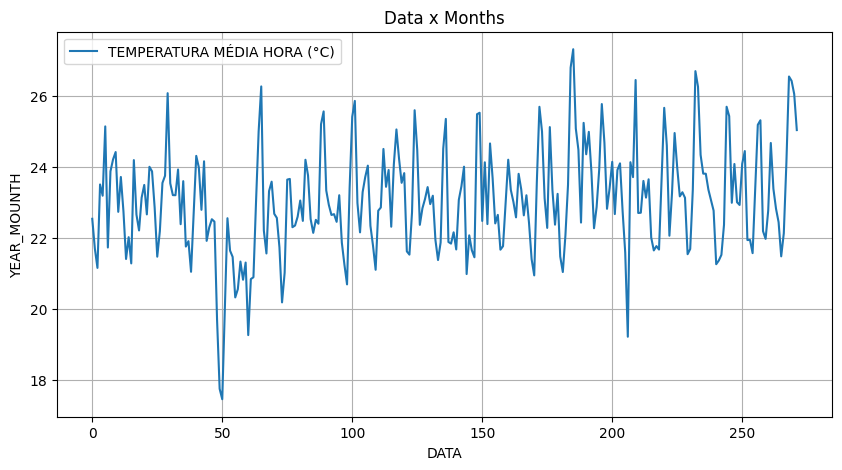

C:\Users\Lucas\AppData\Local\Temp\ipykernel_1220\3641080961.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['MA'] = df_treated['TEMPERATURA MÉDIA HORA (°C)'].rolling(window = 10).mean()
C:\Users\Lucas\AppData\Local\Temp\ipykernel_1220\3641080961.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['S'] = df_treated['denoise_temp'] - df_treated['MA']


<Axes: ylabel='Temperature (deg C)'>

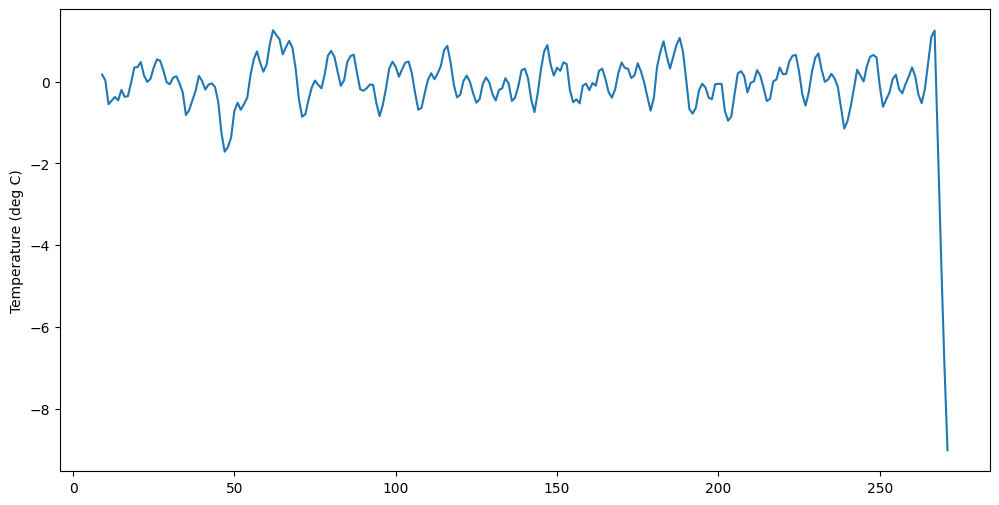

In [78]:
def apply_convolution(x, window):
    conv = np.repeat([0., 1., 0.], window)
    filtered = signal.convolve(x, conv, mode='same') / window
    return filtered
lookback = 12*23
df_treated['denoise_temp'] = apply_convolution(df_treated['TEMPERATURA MÉDIA HORA (°C)'], 10)
plot(df_treated[['TEMPERATURA MÉDIA HORA (°C)', 'year_month']])
df_treated['MA'] = df_treated['TEMPERATURA MÉDIA HORA (°C)'].rolling(window = 10).mean()
plt.ylabel('Temperature (deg C)')
# df_treated['MA'].plot(figsize=(8,4), color="tab:red", title="Rolling mean over annual periods")
df_treated['S'] = df_treated['denoise_temp'] - df_treated['MA']
df_treated['S'].plot(figsize=(12,6))